In [1]:
import os
import numpy as np
from os.path import abspath, exists
from scipy import sparse
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
import numpy.matlib
import random
import scipy.misc


In [3]:
#Randomly pick the centroids
def init_centroids(X,K):
    c = random.sample(list(X),K)
    return c

In [4]:
#We use the Euclidian distance to find the closest centroid
#WIKI:In Cartesian coordinates, if p = (p1, p2,..., pn) and q = (q1, q2,..., qn) are 
#two points in Euclidean n-space, then the distance (d) from p to q, or from q to p is given by 
#the Pythagorean formula
def assign_points_to_centroids(X,centroids):
    K = np.size(centroids,0)
    #Each round we use arr to track each points distance from each centroids
    #The array idx will contain index of the centroid with that the point has min distance
    #For each centroid, there is one column. The function argmin picks the min column and return the index (centroid ID)
    idx = np.zeros((np.size(X,0),1))
    arr = np.empty((np.size(X,0),1))

    for i in range(0,K):
        cent = centroids[i] #pick the first centroid
        temp = np.ones((np.size(X,0),1))*cent #the * will replaces 1 with the an array of RGB
        temp = np.power(np.subtract(X,temp),2) #we are using the euclidian distance. do (x-centroid)^2 
        temp = np.sum(temp,axis = 1)#Do the summation of pythagorean formula  
        temp.resize((np.size(X,0),1)) #The np.sum gives horizontal array. We need to resize it.
        #print(np.shape(a))
        arr = np.append(arr, temp, axis=1)
        #print('shape arr for i={} '.format(i), arr.shape)

    arr = np.delete(arr,0,axis=1)
    idx = np.argmin(arr, axis=1) #The np.argmin give horizontal array
    #print('shape of idx at the end ' , np.shape(idx))
    return idx

In [5]:
#This function does the adjustments.
#This is what differs kmeans to kmedoids
def adjust_centroids(X,idx,K):
    n = np.size(X,1) #Number of columns. In our case is always 3 (RGB)
    centroids = np.zeros((K,n))
    for i in range(0,K):
        temp = idx==i #The result will contain T/F values. 
        temp = temp.astype(int) #Let's change the results to 1 and 0. 1 if the point belong to centroid i, 0 otherwise
        total_number = sum(temp); #total number of points. We will use this to calculate the mean of all points
        temp.resize((np.size(X,0),1)) #from array to one long column of ones
        total_matrix = np.matlib.repmat(temp,1,n) #repeat the 1 column three times (RBG)
        #print("total matrix shape: ",total_matrix.shape)
        temp = np.multiply(X,total_matrix) #filter data to only those belong to centroid i
        centroids[i] = (1/total_number)*np.sum(temp,axis=0) #sum each column and divide by total = average.  
    return centroids

In [6]:
#we have two conditions to stop the run. max_iters and if centroid did not change from one itr to another.
def has_converged (old_centroids, new_centroids):
    return set([tuple(x) for x in old_centroids]) == set([tuple(x) for x in new_centroids])

#the main body of the algorithm
def kMean(X,initial_centroids,max_iters):
    m = np.size(X,0) #number of columns. in this case is 3
    n = np.size(X,1) #number of rows
    K = np.size(initial_centroids,0)
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros((m,1))
    for i in range(1,max_iters):
        idx = assign_points_to_centroids(X,centroids)
        centroids = adjust_centroids(X,idx,K)
        #if has_converged(previous_centroids, centroids):
        #    break
            
    return centroids,idx

In [7]:
################################################
######the new code starts from here. 
################################################

In [8]:
f_path = abspath("edges.txt")
if exists(f_path):
    with open(f_path) as graph_file:
        lines = [line.split() for line in graph_file]
edges = np.array(lines).astype(int)

In [9]:
f_path = abspath("nodes.txt")
if exists(f_path):
    with open(f_path) as graph_file:
        lines = [line.split() for line in graph_file]
nodes = np.array(lines)

In [10]:
n = 1490
k = 2

# let's make sure our index starts from 0 not one.
i = edges[:, 0]-1
j = edges[:, 1]-1
v = np.ones((edges.shape[0], 1)).flatten()

In [11]:
adjacencySparse = sparse.coo_matrix((v, (i, j)), shape=(n, n))
adjacencySparse = (adjacencySparse + np.transpose(adjacencySparse))/2
print(np.shape(adjacencySparse))
#print(adjacencySparse)

(1490, 1490)


In [12]:
# There are many nodes with no edges. We need to remove them from our analysis.
# We need to keep track of them.
# one challenge is how to map back our analysis to the original data. The solution is to eleminate 
# nodes with no edge from the original data, hence what is left is the clean data that can easily can be mapped
# back and forth between our analysis and the clean data.
temp = np.sum(adjacencySparse, axis=1)
#print(temp)
print(np.shape(temp))
print(np.count_nonzero(temp))
#print(np.nonzero(temp))

indx_nonZero, indx_temp = np.nonzero(temp)
print(indx_nonZero)

nodes_clean = nodes[indx_nonZero]
print(nodes_clean)
print(np.shape(nodes_clean))

#let's clean up our sparse (ijv) adjacency matrix.
# the coo (ijv) matrix does not support indexing or slicing. Convert to CSR
# the CSR did not support indexing on both rows and column [indx_nonZero,indx_nonZero]. 
# So one at a time [indx_nonZero, :][:, indx_nonZero]
adjacencySparse = adjacencySparse.tocsr()[indx_nonZero, :][:, indx_nonZero]
print(np.shape(adjacencySparse))
#print(adjacencySparse)

(1490, 1)
1224
[   0    1    4 ... 1487 1488 1489]
[['1' '"100monkeystyping.com"' '0' '"Blogarama"']
 ['2' '"12thharmonic.com/wordpress"' '0' '"BlogCatalog"']
 ['5' '"750volts.blogspot.com"' '0' '"Blogarama"']
 ...
 ['1488' '"zeke01.blogspot.com"' '1' '"Blogarama,BlogCatalog"']
 ['1489' '"zeke01.typepad.com"' '1' '"Blogarama"']
 ['1490' '"zeph1z.tripod.com/blog"' '1' '"Blogarama"']]
(1224, 4)
(1224, 1224)


In [13]:
# now we can create the diagonal degree matrix with no isolated node
# and we will use the one variation of spectral clustering in which we use
# normalized adjacency matrix instead of laplacian matrix. 
degreeM = np.diag(1/np.sqrt(np.sum(adjacencySparse, axis=1)).A1)
#L = degreeM @ adjacencySparse @ degreeM
L = degreeM - adjacencySparse

In [14]:
v, x = np.linalg.eig(L)
x = x[:, 0:k].real
x = x/np.repeat(np.sqrt(np.sum(np.multiply(x,x), axis=1).reshape(-1, 1)), k, axis=1)

# there are four NaN values that I replace them with zero
print(np.sum(np.isnan(x)))
x[np.isnan(x)]=0
print(np.sum(np.isnan(x)))

4
0


/home/hadi/anaconda3/envs/StatisticalLearning/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


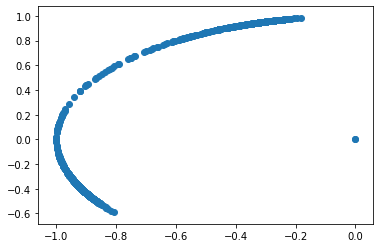

In [15]:
# scatter
plt.scatter([x[:, 0]], [x[:, 1]])
plt.show()

In [16]:
# k-means
#kmeans = KMeans(n_clusters=k).fit(x)
#c_idx = kmeans.labels_

max_iters = 50
initial_centroids = init_centroids(x,2)
centroids,c_idx = kMean(x,initial_centroids,max_iters)
print('shape of the centroids', np.shape(centroids))
print('shape of index or class', np.shape(c_idx))

shape of the centroids (2, 2)
shape of index or class (1224, 1)


In [17]:
# show cluster
error = 0
for i in range(2):
    print(f'Cluster {i+1}\n***************')
    idx = [index for index, t in enumerate(c_idx) if t == i]
    count_0 = 0
    count_1 = 0
    for index in idx:
        print(nodes_clean[index])
        if(nodes_clean[index][2] == '0') : count_0 = count_0 + 1 
        else: count_1 = count_1 + 1 
    print('\n')
    print('number of 0s ',count_0)
    print('number of 1s ',count_1)
    if(count_0 > count_1): error = error + count_1
    else : error = error + count_0

print('\ntotal errors: ', error)
print('false classification rate: ', error/c_idx.size)

Cluster 1
***************
['5' '"750volts.blogspot.com"' '0' '"Blogarama"']
['11' '"adamtalib.blogspot.com"' '0' '"Blogarama"']
['32' '"anarchyxero.robfindlay.org"' '0' '"Blogarama"']
['58' '"awards5.tripod.com/tarasblog"' '0' '"BlogCatalog"']
['80' '"blog.mintruth.com"' '0' '"Blogarama"']
['119' '"buzzmachine.com"' '0' '"BlogPulse,LeftyDirectory"']
['128' '"charleypatton.blogspot.com"' '0' '"BlogCatalog,eTalkingHead"']
['136' '"clarified.blogspot.com"' '0' '"LeftyDirectory,eTalkingHead"']
['173' '"democratvoice.org"' '0' '"Blogarama"']
['184' '"digitaljay.blogspot.com"' '0' '"LeftyDirectory,eTalkingHead"']
['203' '"elderbearden.blogspot.com"' '0' '"Blogarama"']
['213' '"enemykombatant.blogspot.com"' '0' '"BlogCatalog"']
['216' '"estropundit.blogspot.com"' '0' '"eTalkingHead"']
['225' '"forewarned.blogspot.com"' '0' '"eTalkingHead"']
['230' '"fuckthisblog.blogspot.com"' '0' '"Blogarama"']
['249' '"grupo-utopia.com/blog/isou"' '0' '"LabeledManually"']
['267' '"home.earthlink.net/~kevin.